### Double Well potential using OpenMM

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
%%capture
!conda install -c conda-forge openmm mdtraj parmed
!pip install py3dmol 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import openmm as mm

In [3]:
def run_simulation(n_steps=10000):
    "Simulate a single particle in the double well"
    
    system = mm.System()
    system.addParticle(1)# added particle with a unit mass
    force = mm.CustomExternalForce('2*(x-1)^2*(x+1)^2 + y^2')# defines the potential
    force.addParticle(0, [])
    system.addForce(force)
    integrator = mm.LangevinIntegrator(500, 1, 0.02) # Langevin integrator with 500K temperature, gamma=1, step size = 0.02
    context = mm.Context(system, integrator)
    context.setPositions([[0, 0, 0]])
    context.setVelocitiesToTemperature(500)
    x = np.zeros((n_steps, 3))
    
    for i in range(n_steps):
        x[i] = context.getState(getPositions=True).getPositions(asNumpy=True)._value
        integrator.step(1)
        
    return x

In [4]:
trajectory = run_simulation(25000)



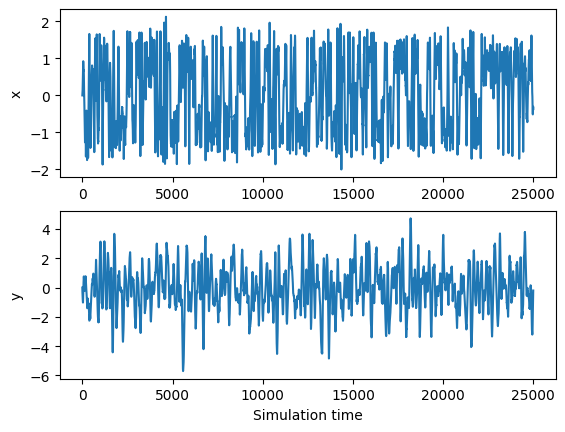

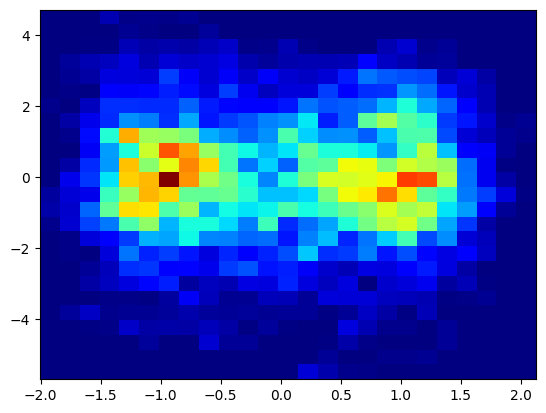

In [5]:
ylabels = ['x', 'y']

for i in range(2):
    plt.subplot(2, 1, i+1)
    plt.plot(trajectory[:, i])
    plt.ylabel(ylabels[i])
plt.xlabel('Simulation time')
plt.show()

plt.hist2d(trajectory[:, 0], trajectory[:, 1], bins=(25, 25), cmap=plt.cm.jet)
plt.show()

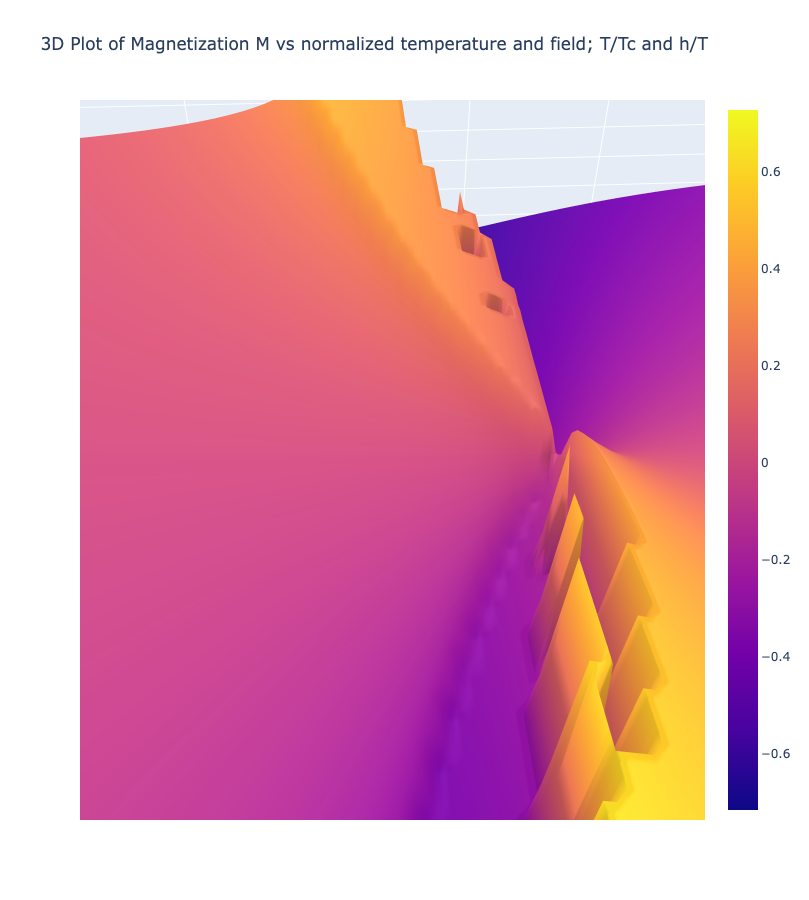

In [38]:
import plotly.graph_objects as go
import numpy as np
from scipy.optimize import fsolve

# Define the self-consistent equation for M
def mean_field_eq(M, T, h_over_T):
    Tc = 1.0  # We can set Tc = 1 for normalized temperature calculations
    h = h_over_T * T  # Compute actual h from h/T and T
    return M - np.tanh((M + h) / (T / Tc))

# Define ranges for h/T (from -0.2 to 0.2) and T/Tc (from 0 to 1.5)
h_over_T_values = np.linspace(-0.1, 0.1, 100)
temperature_over_Tc_values = np.linspace(0.2, 1.5, 100)

# Create a meshgrid for T/Tc and h/T
H_over_T, T_over_Tc = np.meshgrid(h_over_T_values, temperature_over_Tc_values)

# Initialize an array for magnetizations
Magnetizations = np.zeros_like(H_over_T)

# Compute M for each (h/T, T/Tc) pair in the meshgrid
for i in range(len(temperature_over_Tc_values)):
    for j in range(len(h_over_T_values)):
        T_actual = temperature_over_Tc_values[i]  # This is actually T/Tc
        h_over_T_actual = h_over_T_values[j]
        # Solve for M using fsolve, starting from M=0 as initial guess
        M_sol = fsolve(mean_field_eq, x0=0.01, args=(T_actual, h_over_T_actual))
        Magnetizations[i, j] = M_sol[0]

# Create a 3D surface plot using Plotly
fig = go.Figure(data=[go.Surface(z=Magnetizations, x=H_over_T, y=T_over_Tc)])

# Update plot layout
fig.update_layout(
    title='3D Plot of Magnetization M vs normalized temperature and field; T/Tc and h/T',
    scene=dict(
        xaxis_title='h/T',
        yaxis_title='T/Tc',
        zaxis_title='M',
        aspectmode='manual',
        aspectratio=dict(x=2, y=2, z=0.5),  # Adjust these values as needed
    ),
    autosize=False,
    width=900,
    height=900
)

# Show the figure
fig.show()
